# Example 1 - Beginner Friendly
In this Data Analysis will be to practice with `Python and libraries`

[Digimon DB KAGGLE](https://www.kaggle.com/datasets/rtatman/digidb)

This dataset contains information on digimon from “Digimon Digimon Story: Cyber Sleuth”, released for Playstation Vita in 2015 and Playstation 4 in 2016.

**Content:**

This database contains three files: a list of all the digimon that can be captured or fought in Cyber Sleuth, all the moves which Digimon can perform, and all the Support Skills. (Support Skills are a passive, stackable, team-wide buff. Each species of Digimon is associated with a single Support Skill.)

* Which set of moves will get the best ratio of attack power to SP spent?
* Which team of 3 digimon have the highest attack? Defense?
* What’s the tradeoff between HP and SP?
* Are some types over- or under-represented?
* Both the moves and support skills have short text descriptions. Can an NLP analysis reveal underlying clusters of moves?
* Are different types and attributes evenly represented across stages?

## 1. Dependency and Format

Python 3.10.11


In [79]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from skimpy import clean_columns
from wordcloud import WordCloud

import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [80]:
# Display float with 2 decimal values
pd.options.display.float_format = '{:.2f}'.format

#### Helpers

In [81]:
# Checking if I can change the types to more efficient memory usage
import numpy as np

np.iinfo(np.int16)

iinfo(min=-32768, max=32767, dtype=int16)

In [82]:
from IPython.display import display
def create_var(df,var_name):
    """This function is to create a variable with the main DataFrame without change the main one
    Use it when you have to debug or modify anything"""
    globals()[var_name] = df
    return df

## 2. Get and Inspect Data

In [83]:
db = pd.read_csv('data/db_digimonlist.csv')
db_move= pd.read_csv('data/db_movelist.csv')
db_support= pd.read_csv('data/db_supportlist.csv')

In [84]:
# Sample data
db.sample(5)

,Number,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
202,203,Barbamon,Mega,Virus,Dark,22,1,1330,184,84,129,233,133
167,168,UlforceVeedramon,Mega,Vaccine,Wind,22,1,1680,129,188,109,104,198
199,200,Leopardmon,Mega,Data,Light,22,1,990,188,124,114,183,188
108,109,MegaKabuterimon,Ultimate,Vaccine,Plant,12,2,1430,115,94,163,109,92
53,54,Wormmon,Rookie,Free,Plant,4,1,760,76,92,111,90,71


In [85]:
# Setting the right index
db.set_index('Number',inplace=True)
db.index.name = None
db.head()

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
1,Kuramon,Baby,Free,Neutral,2,0,590,77,79,69,68,95
2,Pabumon,Baby,Free,Neutral,2,0,950,62,76,76,69,68
3,Punimon,Baby,Free,Neutral,2,0,870,50,97,87,50,75
4,Botamon,Baby,Free,Neutral,2,0,690,68,77,95,76,61
5,Poyomon,Baby,Free,Neutral,2,0,540,98,54,59,95,86


In [86]:
cols = db.columns.to_list()
cols

['Digimon',
 'Stage',
 'Type',
 'Attribute',
 'Memory',
 'Equip Slots',
 'Lv 50 HP',
 'Lv50 SP',
 'Lv50 Atk',
 'Lv50 Def',
 'Lv50 Int',
 'Lv50 Spd']

In [87]:
# Get an overview of the data
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 1 to 249
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Digimon      249 non-null    object
 1   Stage        249 non-null    object
 2   Type         249 non-null    object
 3   Attribute    249 non-null    object
 4   Memory       249 non-null    int64 
 5   Equip Slots  249 non-null    int64 
 6   Lv 50 HP     249 non-null    int64 
 7   Lv50 SP      249 non-null    int64 
 8   Lv50 Atk     249 non-null    int64 
 9   Lv50 Def     249 non-null    int64 
 10  Lv50 Int     249 non-null    int64 
 11  Lv50 Spd     249 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 25.3+ KB


In [88]:
# Generate descriptive statistics
db.describe().T

,count,mean,std,min,25%,50%,75%,max
Memory,249.00,11.99,6.62,2.00,6.00,12.00,18.00,25.00
Equip Slots,249.00,1.57,0.85,0.00,1.00,1.00,2.00,3.00
Lv 50 HP,249.00,1210.88,326.10,530.00,990.00,1180.00,1480.00,2080.00
Lv50 SP,249.00,109.78,32.45,50.00,84.00,104.00,132.00,203.00
Lv50 Atk,249.00,124.52,45.64,52.00,89.00,119.00,153.00,318.00
Lv50 Def,249.00,116.38,32.13,59.00,93.00,113.00,138.00,213.00
Lv50 Int,249.00,112.64,41.56,50.00,79.00,104.00,138.00,233.00
Lv50 Spd,249.00,120.40,32.63,61.00,92.00,119.00,143.00,218.00


In [89]:
db = (db
[cols]
.astype({'Memory': 'int16',
 'Equip Slots': 'int16',
 'Lv 50 HP': 'int16',
 'Lv50 SP': 'int16',
 'Lv50 Atk': 'int16',
 'Lv50 Def': 'int16',
 'Lv50 Int': 'int16',
 'Lv50 Spd': 'int16'}) )

In [90]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 1 to 249
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Digimon      249 non-null    object
 1   Stage        249 non-null    object
 2   Type         249 non-null    object
 3   Attribute    249 non-null    object
 4   Memory       249 non-null    int16 
 5   Equip Slots  249 non-null    int16 
 6   Lv 50 HP     249 non-null    int16 
 7   Lv50 SP      249 non-null    int16 
 8   Lv50 Atk     249 non-null    int16 
 9   Lv50 Def     249 non-null    int16 
 10  Lv50 Int     249 non-null    int16 
 11  Lv50 Spd     249 non-null    int16 
dtypes: int16(8), object(4)
memory usage: 13.6+ KB


In [91]:
# Check missing values 
db.isna().sum()

Digimon        0
Stage          0
Type           0
Attribute      0
Memory         0
Equip Slots    0
Lv 50 HP       0
Lv50 SP        0
Lv50 Atk       0
Lv50 Def       0
Lv50 Int       0
Lv50 Spd       0
dtype: int64

In [92]:
# Check for missing  values in %
db.isna().mean().mul(100)
# Mean is the AVG and its multiply by 100

Digimon       0.00
Stage         0.00
Type          0.00
Attribute     0.00
Memory        0.00
Equip Slots   0.00
Lv 50 HP      0.00
Lv50 SP       0.00
Lv50 Atk      0.00
Lv50 Def      0.00
Lv50 Int      0.00
Lv50 Spd      0.00
dtype: float64

In [93]:
# Display rows with missing values
db[db.isnull().any(axis='columns'   )]

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd


In [94]:
# Inspect highest avg percentage Attack / Defense
db.nlargest(5,columns=['Lv50 Atk', 'Lv50 Def'])

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
244,Chaosmon,Ultra,Vaccine,Neutral,25,2,1080,129,318,94,89,188
236,Belphemon RM,Ultra,Virus,Dark,25,0,1780,84,247,168,109,140
196,Diaboromon,Mega,Free,Dark,20,2,1680,114,243,104,79,173
242,Beelzemon BM,Mega,Virus,Dark,25,1,1680,114,238,124,104,178
212,Beelzemon,Mega,Virus,Dark,22,1,1680,114,228,119,99,168


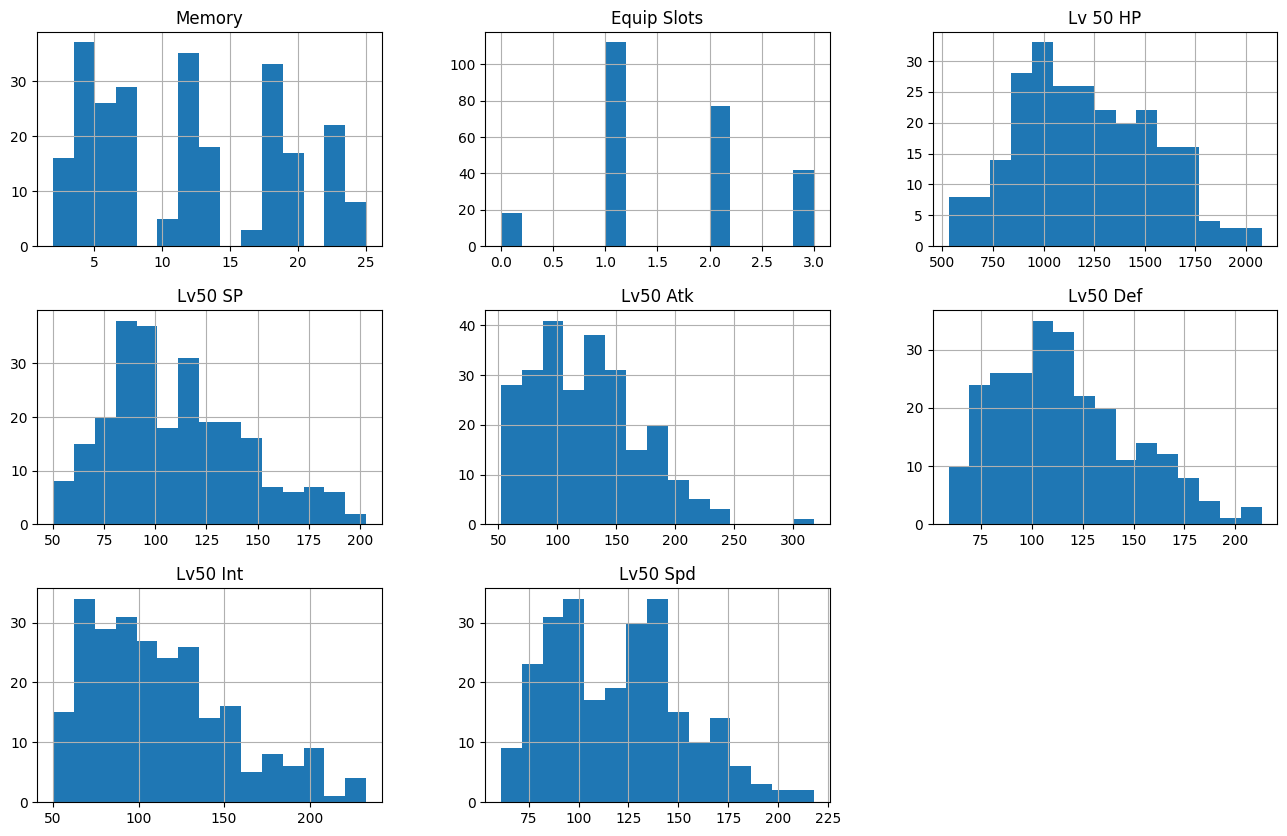

In [95]:
# Most Features (columns) are showing a difference between mean and median
# This indicates that the data is skewed
hist = db.hist(bins=15, figsize=(16,10))

* `As we can see here we have `OUTLIERS in ATK`, also we have less than 10 Digimons with a high performance`

In [96]:
# Which set of moves will get the best ratio of attack power to SP spent?
db_move

,Move,SP Cost,Type,Power,Attribute,Inheritable,Description
0,Wolkenapalm I,3,Physical,65,Fire,Yes,"Physical attack, 65 Fire damage to one foe. 95..."
1,Wolkenapalm II,6,Physical,85,Fire,Yes,"Physical attack, 85 Fire damage to one foe. 95..."
2,Wolkenapalm III,9,Physical,105,Fire,Yes,"Physical attack, 105 Fire damage to one foe. 9..."
3,Burst Flame I,3,Magic,55,Fire,Yes,"Magic attack, 55 Fire damage to one foe. 95% a..."
4,Burst Flame II,6,Magic,75,Fire,Yes,"Magic attack, 75 Fire damage to one foe. 95% a..."
...,...,...,...,...,...,...,...
382,Garuru Tomahawk,20,Physical,140,Neutral,No,"Physical attack, 140 Neutral damage to one foe..."
383,Fist of Athena,50,Physical,0,Fire,No,"DEF-penetrating attack, triple Fire damage to ..."
384,Supreme Cannon,30,Magic,130,Water,No,"Magic attack, 130 Water damage to one foe."
385,Dark Prominence,30,Magic,0,Dark,No,INT-penetrating Dark attack to one foe. 50% ch...


### HeatMaps with PANDAS and SNS

In [97]:
# Check correlation of the features (columns)
(db.corr().style.background_gradient(cmap='RdBu', vmin=-1, vmax=1))

C:\Users\herre\AppData\Local\Temp\ipykernel_10336\3119373488.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
Memory,1.000000,0.355176,0.639569,0.623400,0.608372,0.611728,0.583956,0.797777
Equip Slots,0.355176,1.000000,0.392137,0.278687,0.211450,0.466534,0.237616,0.286558
Lv 50 HP,0.639569,0.392137,1.000000,0.070957,0.605708,0.561376,0.055314,0.317051
Lv50 SP,0.623400,0.278687,0.070957,1.000000,-0.148365,0.169960,0.895652,0.603240
Lv50 Atk,0.608372,0.211450,0.605708,-0.148365,1.000000,0.426901,-0.186125,0.522005
Lv50 Def,0.611728,0.466534,0.561376,0.169960,0.426901,1.000000,0.182606,0.225921
Lv50 Int,0.583956,0.237616,0.055314,0.895652,-0.186125,0.182606,1.000000,0.442214
Lv50 Spd,0.797777,0.286558,0.317051,0.603240,0.522005,0.225921,0.442214,1.000000


C:\Users\herre\AppData\Local\Temp\ipykernel_10336\1040210664.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



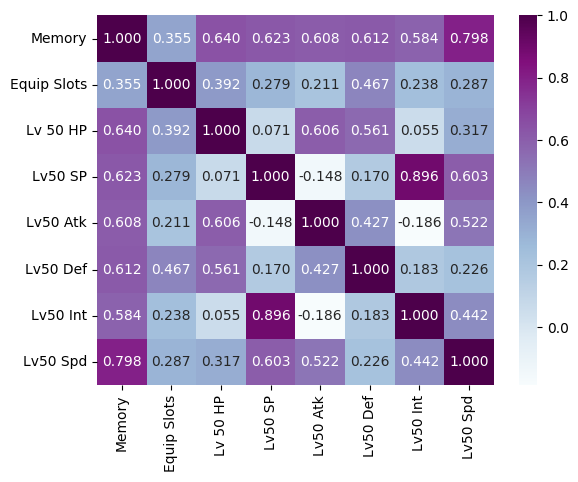

In [98]:
# Plot HeatMap with SNS
heatmap= sns.heatmap(db.corr(), cmap='BuPu', annot=True, fmt='.3f')

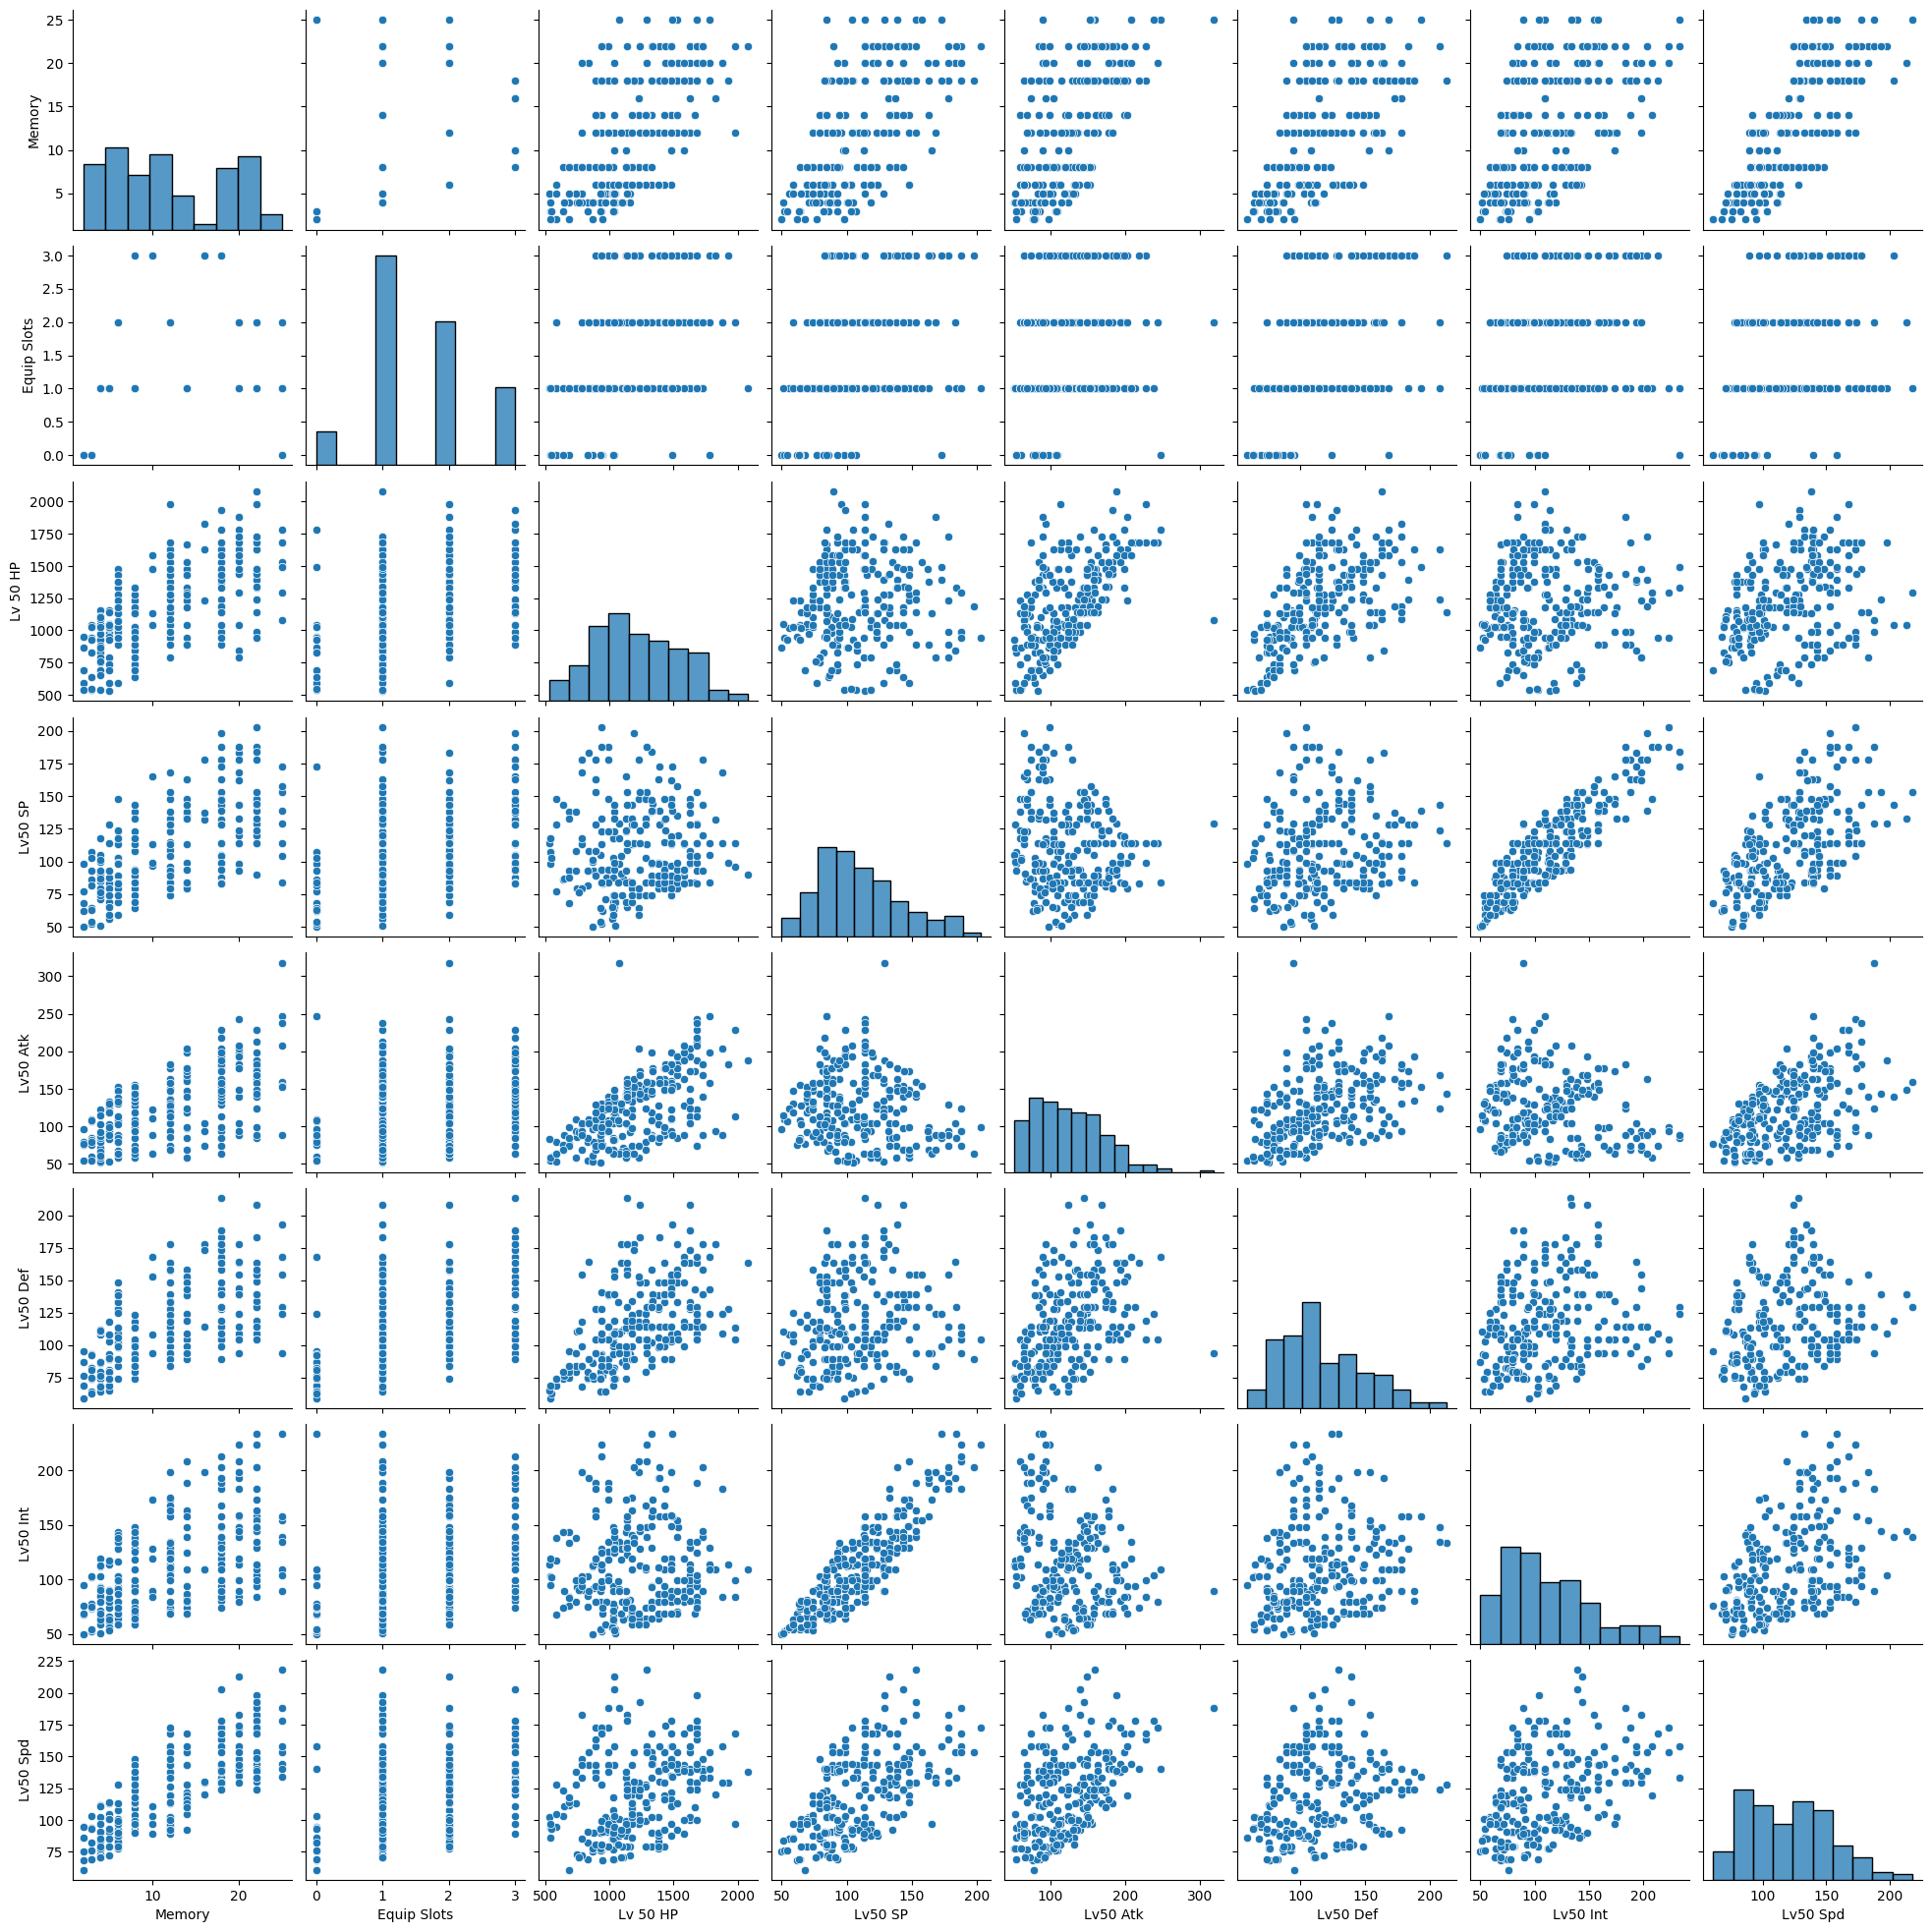

In [99]:
# Plot pairwise relationships
sns.pairplot(db)

In [100]:
# Show outliers
db['Lv50 Atk'].nlargest()

244    318
236    247
196    243
242    238
185    228
Name: Lv50 Atk, dtype: int16

In [101]:
# Set upper limit for outliers
q_hi=db['Lv50 Atk'].quantile(0.99)
q_hi

240.60000000000005

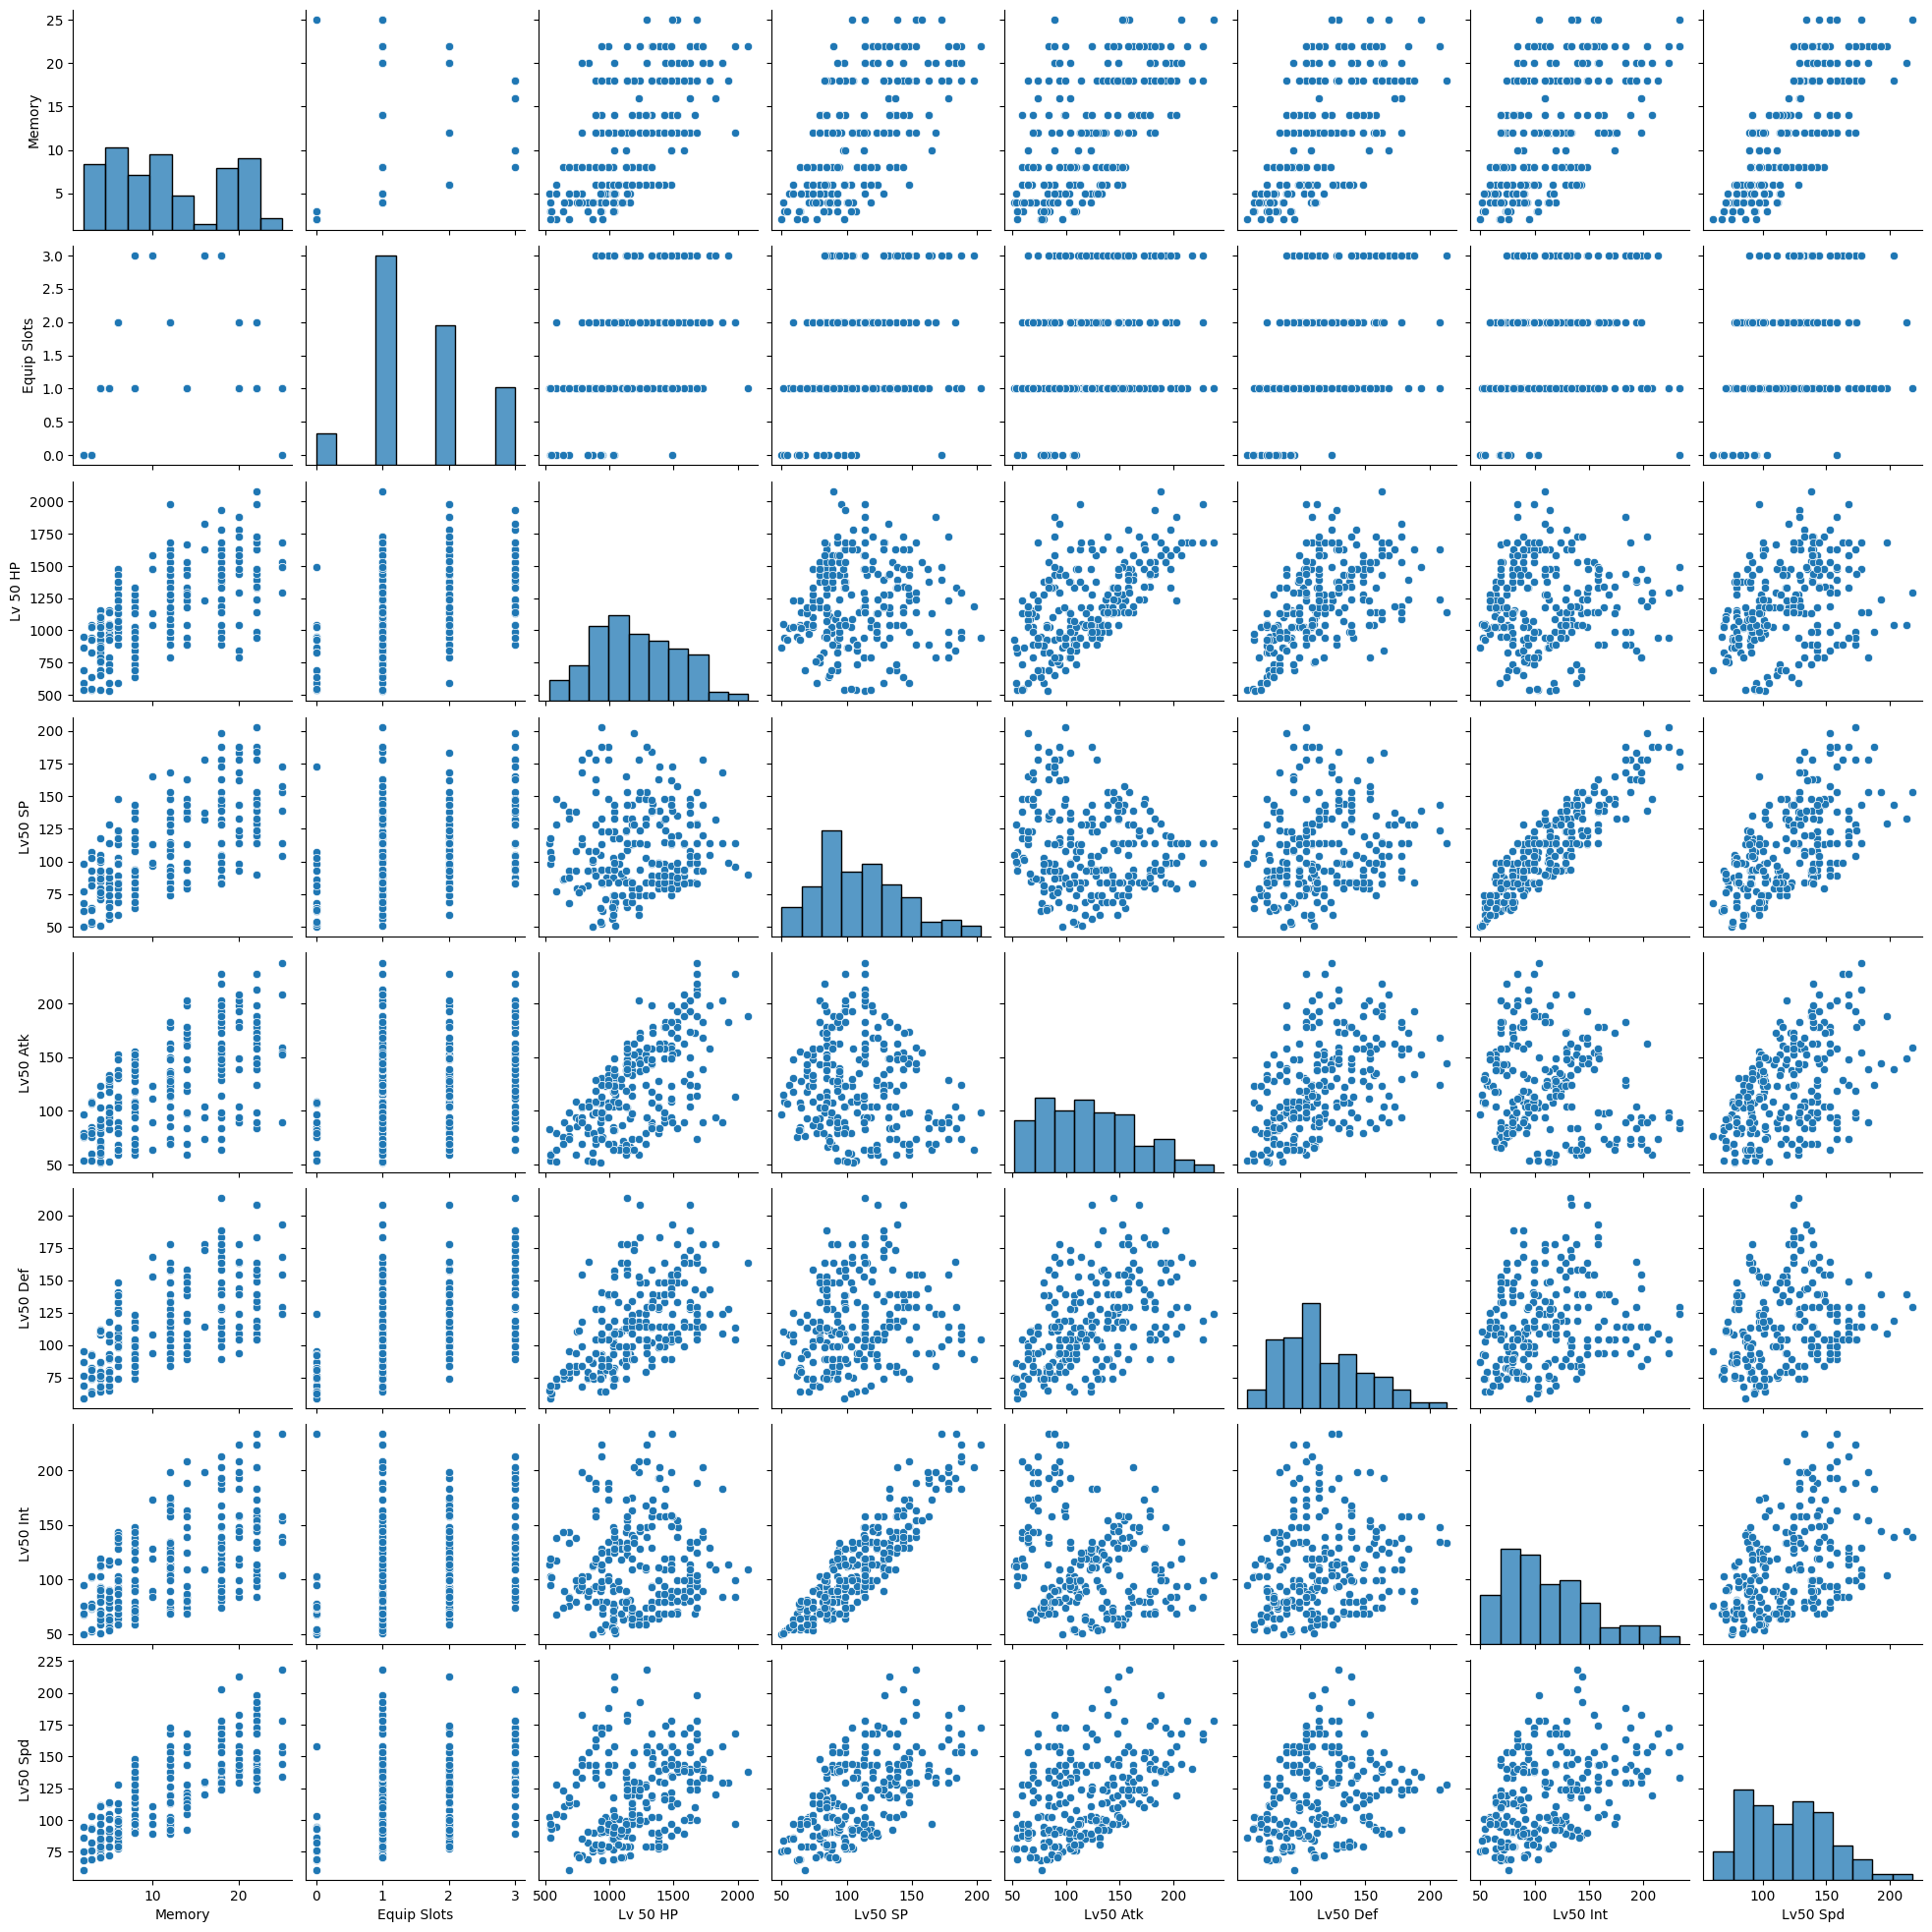

In [102]:
# Plot pairwise relationships w/o outliers
sns.pairplot(db.query("`Lv50 Atk` < @q_hi"))

## 3. Clean up the DataFrame

### 3.1 Using pandas to clean the data with method chaining

In [103]:
# Chain PANDAS method
( db.query('`Lv50 Atk` > 100') # Using SQL method
 .filter(regex='^D',axis='columns') # Filter with regex all the COLUMNS NAME start with D
 .rename(columns={'Digimon':'Digimon_Name'}) # Rename the Column Name-
 )

,Digimon_Name
6,Koromon
8,Tsunomon
9,Tsumemon
17,Agumon
18,Agumon (Blk)
...,...
245,Valkyrimon
246,ShineGreymon BM
247,MirageGaogamon BM
248,Ravemon BM


In [ ]:
df[cols].value_counts().values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [104]:
db.head(3)

,Digimon,Stage,Type,Attribute,Memory,Equip Slots,Lv 50 HP,Lv50 SP,Lv50 Atk,Lv50 Def,Lv50 Int,Lv50 Spd
1,Kuramon,Baby,Free,Neutral,2,0,590,77,79,69,68,95
2,Pabumon,Baby,Free,Neutral,2,0,950,62,76,76,69,68
3,Punimon,Baby,Free,Neutral,2,0,870,50,97,87,50,75


In [105]:
# Function to CLEAN
def clean_df(df, views_threshold=100):
    """
    Purpose: Clean the DataFrame 
    """
   #  remove_cols=['Number']
    # remove_nan_values=['']
    return(df
         #   .drop(labels=remove_cols,axis='columns')
        #    .dropna(subset=remove_nan_values)
           .dropna()
           .pipe(clean_columns) # Cleaning empty spaces and special characters. Imported at the beginning
           .rename(columns={'lv_50_hp':'hp',
                            'lv_50_sp':'sp', 
                            'lv_50_atk':'atk',
                            'lv_50_def':'def',
                            'lv_50_int':'int',
                            'lv_50_spd':'spd'
                            }
                   )
           .query('atk > @views_threshold')
           .assign( # assign create a new column or edit the existing one
        #        atk=lambda df_: pd.to_datetime(df_.)
               atk_sp_ratio=lambda df_: ((df_.sp /df_.atk)*100).round(2)
           )
           )
# end def

df = clean_df(db)
df.head(3)

12 column names have been cleaned

,digimon,stage,type,attribute,memory,equip_slots,hp,sp,atk,def,int,spd,atk_sp_ratio
6,Koromon,In-Training,Free,Fire,3,0,940,52,109,93,52,76,47.71
8,Tsunomon,In-Training,Free,Earth,3,0,930,54,107,92,54,76,50.47
9,Tsumemon,In-Training,Free,Dark,3,0,930,64,108,64,54,93,59.26


## 4. Plot data

### 4.1 Time Series Analysis

In [106]:
cols

['Digimon',
 'Stage',
 'Type',
 'Attribute',
 'Memory',
 'Equip Slots',
 'Lv 50 HP',
 'Lv50 SP',
 'Lv50 Atk',
 'Lv50 Def',
 'Lv50 Int',
 'Lv50 Spd']

In [107]:
stage_cnt = data.Stage.value_counts()
fig = px.bar(stage_cnt, x=stage_cnt.index, y=stage_cnt, labels={'y':'count', 'index':'Stage'}, 
             color_continuous_scale='Civids')
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.show()

NameError: name 'data' is not defined

In [ ]:
df.stage.value_counts()

Mega           57
Ultimate       45
Champion       35
Rookie         12
Ultra           5
In-Training     3
Armor           3
Name: stage, dtype: int64

In [ ]:
(df
 .stage
 .value_counts())[0]

57

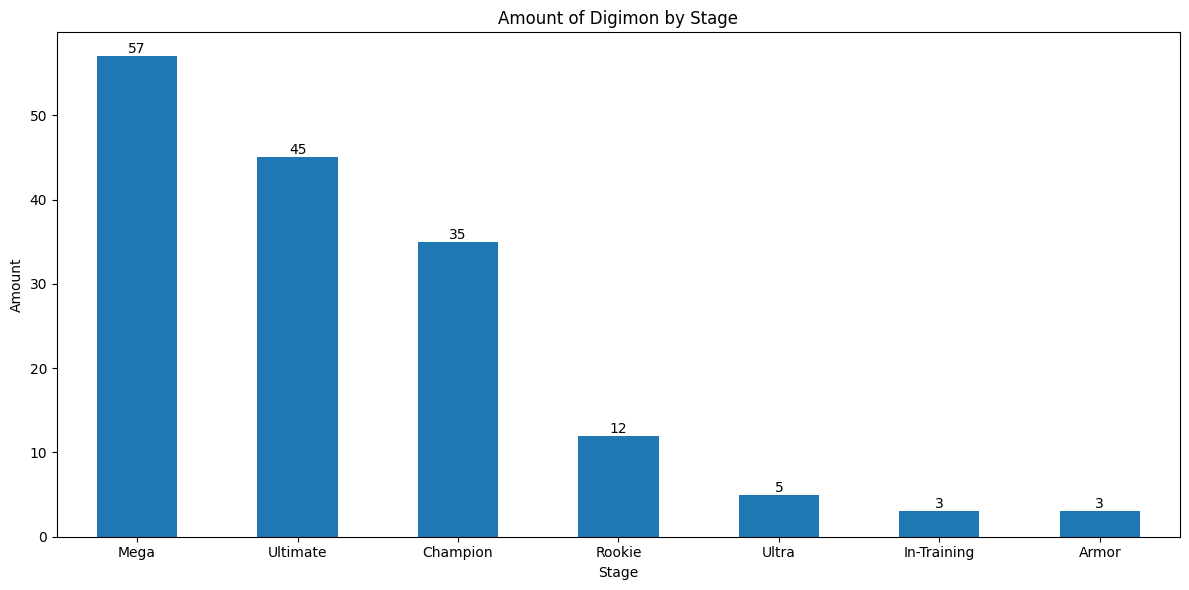

In [ ]:
ax = (df
 .stage
 .value_counts()
 .plot(kind='bar',figsize=(12,6),rot=0, title='Amount of Digimon by Stage', xlabel='Stage', ylabel='Amount')
 )
ax.bar_label(ax.containers[0])

plt.tight_layout()



#### Which team of 3 digimon have the highest attack? Defense?


In [29]:
df_pie = df.groupby("attribute").stage.value_counts(ascending=False)

In [598]:

def plot_column(df, column, top_values=10, color="#d33682"):
    df_total = []
    title = f"<b>{column[0].replace('_',' ').title()} and {column[1].replace('_',' ').title()} - Top {top_values} Digimons</b>"
    mean = df[column].mean()
    median = df[column].median()
    fig = make_subplots(rows=2, cols=1, subplot_titles=(f"{column[0].replace('_',' ').title()}", f"{column[1].replace('_',' ').title()}"),shared_xaxes=False, shared_yaxes=False,vertical_spacing=0.1,)
    for i,col  in enumerate(column):
        df_col = df.nlargest(top_values, columns=col).sort_values(by=col, ascending=True)
        df_total.append(df_col)
        mean= df_total[i][column[i]].mean()
        median= df_total[i][column[i]].median()
        # Plot 1 - Bar chart
        fig.add_trace(
            go.Bar(
                x=df_total[i][col],
                y=df_total[i]['digimon'],
                      
                orientation="h",
                marker_color=color,
                text=df_total[i]['type'],
                opacity=1,
                hovertemplate="<b> Digimon:%{y} </br><b> "f'{col.title()}'":%{x} <br> Type:%{text}",
                name='',
                
            ),
            row=i+1,
            col=1,
        )

        # add a vertical "MEAN" line
        fig.add_shape(
            type="line",
            x0=mean,
            y0=0,
            x1=mean,
            y1=top_values-0.5,
            line=dict(color="purple", width=3, dash="dot"),
            row=i+1,
            col=1,
            visible=True,
            templateitemname=mean,
            name='mean'
            )
        # Add a text annotation for the MEAN value
        fig.add_annotation(
                x=mean,
                y=top_values,
                text='Mean',
                hovertext=f"Mean: {mean:.2f}",                
                align="center",
                row=i+1, 
                col=1,
                textangle=50,
                font=dict(size=10,color="gray"),
                xshift=-10,
            )

        # add a vertical "MEDIAN" line
        fig.add_shape(
            type="line",
            x0=median,
            y0=0,
            x1=median,
            y1=top_values -0.5,
            line=dict(color="salmon", width=3, dash="dot"),
            row=i+1,
            col=1,
        )
        # Add a text annotation for the MEDIAN value
        fig.add_annotation(
            x=median,
            xref="x",
            y=top_values,
            yref="y",
            text='Median',
            hovertext=f"Median: {median:.2f}",
            align="center",
            row=i+1, 
            col=1,
            textangle=50,
            font=dict(size=10,color="gray"),
        opacity=1,
        )


    fig.update_layout(
        title_text=title,
        uirevision=dict(editable=False),
        bargap=0,
        yaxis1=(dict(showgrid=False, title=None,showticklabels=True,visible=True,zeroline=False)),
        yaxis2=(dict(showgrid=False, title=None,showticklabels=True,)),
        xaxis1=(dict(showgrid=False, title=None, showticklabels=True,visible=True,zeroline=False)),
        xaxis2=(dict(showgrid=False, title=None, showticklabels=True,visible=True,zeroline=False)),
        margin=dict(l=0, r=0, t=50, b=15),
        showlegend=False,
        hoverlabel=dict(
            bgcolor="#ff8fc5",
            font_family="Times New Roman",
            ),
        template="plotly_white",
        
        annotations=[
        dict(
            showarrow=False,
            )
    ],
        )
    return fig
fig = plot_column(df=df , column=['atk','def'], top_values=3)
fig.show()

This is the format of your plot grid:
[ (1,1) x,y   ]
[ (2,1) x2,y2 ]



In [31]:
db_move.columns.tolist()

['Move', 'SP Cost', 'Type', 'Power', 'Attribute', 'Inheritable', 'Description']

In [32]:
db_move.columns.str.lower()

Index(['move', 'sp cost', 'type', 'power', 'attribute', 'inheritable',
       'description'],
      dtype='object')

In [67]:

fig = px.bar(
        df,
        x=df.type.unique().tolist(),
        y=df.type.value_counts(),
        title='Types',
        template="plotly_white",
        
    )
fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        yaxis=(dict(showgrid=False, title=None)),
        xaxis=(dict(showgrid=False, title=None)),
        margin=dict(l=0, r=0, t=50, b=5),
    )
fig.update_traces(texttemplate='%{value}', textposition='outside')

fig.show()

In [ ]:
# OPTIONAL
fig.write_html('digimon-chart.html')

In [35]:
df_move.groupby(["type"]).mean()

C:\Users\herre\AppData\Local\Temp\ipykernel_28180\1191319914.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,sp_cost,power,power_sp_ratio
type,,,
Magic,20.75,113.25,18.27
Physical,17.34,125.95,13.88
